# **Neural Network Aimbot**
Counter Strike player detection, classification, and localization

Kyle Pish

CS387

Final Project


---



# **Introduction**

The goal of this project was to learn more and explore the world of deep learning, specifically the area of object detection. With very minimal prior knowledge to beginning this project, the obvious first step was research. The inspiration for this project came from two sources. Firstly, the rapidly growing prominence of object detection in our day to day lives in things such as self-driving cars, facial recognition, etc. Secondly, my lifelong interest in video games, specifically Counter Strike.

## Goal
The goal of this project was to develop the framework for an Aimbot application utillizing neural networks. Due to the complexity of the task of object detection, I decided to do a comparsion between two models. Firstly, I would build a custom model with the knowledge I learned in class along with some extra reasearch. Secondly I would use one of the most highly reguarded pre-trained object detection models YOLOv5.

# **Important Knowledge**

With a task this complex, it's crucial to have a solid understanding of deep learning strategies and exactly what the model is doing, so let's talk about some of the concepts used in this project.

- Object Detection, Classification, & Localization:
    - Object detection is a combination of two things, object classification which involves classifying images based on the objects contained in them such as the two teams of CT and T in this project, and object localization which is finding the locations of objects in an image and drawing a bounding box at the objects coordinates. These two concepts are combined to form the more complex task known as object detection.

- RoboFlow:
    - Roboflow is an application which allows for easy creation of datasets. After collecting my data of nearly 4000 images and labels, Roboflow simply splits the data into a train/val/test split of sizes of your choice. It also allows for easy data augmentation such as image resizing, recoloring, shifting/rotating, etc.

- OpenCV:
    - Open Source Computer Vision Library, is an open-source computer vision and software library. In this project, OpenCV is used for a variety of image processing tasks such as reading image files, resizing, converting colors, and drawing bounding boxes on images.
- TensorFlow:
    - TO BE COMPLETED
- Intersection over Union:
    - IoU is a measure to evaluate the accuracy of object detection. It measures the overlap between the predicted bounding box and the real bounding box. It is the ratio of the area of intersection to the area of union between the two bounding boxes.
- Convolution:
    - A very important aspect of deep learning for extracting features from input data. In convolutional neural networks (CNNs), convolutional layers use a series of filters and apply them to input images to detect patterns and features. The filters move over the input data and perform multiplication and sum operations on each element, resulting in a feature map.
- YOLOv5:
    - One of the most well known pre-trained models for object detection, known for its high accuracy and speed, making it perfect for real-time object detection

With all of that out of the way, let's get to the models!

# **Imports and Setup**

In [ ]:
!pip install -q roboflow && echo "Roboflow installation successful"
!pip install -q tensorflow && echo "TensorFlow installation successful"
!pip install -q opencv-python && echo "OpenCV installation successful"

Roboflow installation successful
TensorFlow installation successful
OpenCV installation successful


In [ ]:
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt
from google.colab import files
from roboflow import Roboflow
import tensorflow as tf
import numpy as np
import cv2 as cv
import shutil
import torch
import glob
import os

print(tf.__version__)

2.15.0




---



# **Dataset Information**

This custom dataset consists of nearly 4000 annotated images of players from the video game Counter Strike. I collected the images while playing Counter Strike and running a simple python script to automatically take screenshots. With over 10,000 images collected, I used LabelImg to draw bounding boxes and create labels for each piece of data. With the completely labeled data, I uploaded them to Roboflow where the images and labels were processed and placed into seperate training, validation, and test sets with some slight augmentation such as resizing.

Check out the data set here:
https://universe.roboflow.com/counter-strike-uovxc/counter-strike-h9y80

---

# **Custom Model**

## Data Setup

Before we do anything, we need to access our dataset, as I said earlier Roboflow is a super simple method of creating datasets, and to make it even easier they provide this block of code to import your custom dataset directly into your project. With the data imported we can define paths to the specific data we will need to access.

In [ ]:
rf = Roboflow(api_key="X1WLdPiFrXXFn4rJIKPE")
project = rf.workspace("counter-strike-uovxc").project("counter-strike-h9y80")
version = project.version(1)
dataset = version.download("yolov5")

loading Roboflow workspace...
loading Roboflow project...


In [ ]:
image_folder = "Counter-Strike-1/train/images"
label_folder = "Counter-Strike-1/train/labels"

In [ ]:
test_images = "Counter-Strike-1/test/images"
test_labels = "Counter-Strike-1/test/labels"

Roboflow with split up images and labels into two different folders, with this function we can combine the image and label folder, now all images and their corresponding labels can be accessed from the same location


Note that all labels have the same name as their corresponding image, just with different file extensions
- For Example:
  - Label -> cs_data1.txt
  - Image -> cs_data1.jpg

In [ ]:
def merge_folders(image_folder, text_folder, output_folder):
    # Create the output folder
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Copy images to the output folder
    for image_file in os.listdir(image_folder):
        shutil.copy(os.path.join(image_folder, image_file), output_folder)

    # Copy text files to the output folder
    for text_file in os.listdir(text_folder):
        shutil.copy(os.path.join(text_folder, text_file), output_folder)

In [ ]:
output_folder = "Counter-Strike-1/train/train_data"

merge_folders(image_folder, label_folder, output_folder)

In [ ]:
test_output_folder = "Counter-Strike-1/test/test_data"

merge_folders(test_images, test_labels, test_output_folder)

Let's make sure everything got imported and combined correctly. We can call for a sample image from the training set, then we can get the label using the same path, except with a different file extension. This can be done by slicing off the .jpg and adding on the .txt extension in its place:

  - label_path = img_path[ 0 : -4 ] + '.txt'

Counter-Strike-1/train/train_data/csdata_10-2-_png.rf.6cd00810b107c31f6f13ae7e5cb6d579.jpg


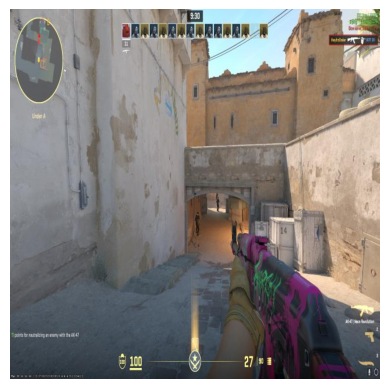

In [ ]:
# Display sample image
sample_img_path = 'Counter-Strike-1/train/train_data/csdata_10-2-_png.rf.6cd00810b107c31f6f13ae7e5cb6d579.jpg'
print(sample_img_path)
sample_img = cv.imread(sample_img_path, cv.IMREAD_COLOR)
plt.imshow(cv.cvtColor(sample_img, cv.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

In [ ]:
# Display sample label
sample_label_path = sample_img_path[0:-4] + '.txt'
with open(sample_label_path) as f:
    print(f.readlines())

['0 0.50703125 0.57421875 0.01328125 0.06328125\n', '0 0.56171875 0.5265625 0.0078125 0.034375\n', '1 0.55625 0.50078125 0.00546875 0.01171875']


Fantastic, looks like everything is going smooth so far. Next lets clean up the data a little more. Due to the simplicity of my custom model, detecting multiple players is a real challenge, so for now we will get rid of them. This is accomplished by checking labels to see whether or not they have multiple entries in them, and if so that label and its corresponding image will not be included in the data to be used in the model. To 'discard' invalid data, a list will be created containing only the file names of valid data. This function also will keep track of how many valid files and invalid files there were, as well as track how many instances of one class were included so we can ensure their is a fair and even distribution.

In [ ]:
def list_files(data_path, image_ext='.jpg'):
    # List of valid data entries
    files = []

    discarded = 0
    t_instance = 0

    for r, d, f in os.walk(data_path):
        for file in f:
            # Open .txt files
            if file.endswith(".txt"):
                # Check if there is only one object, if more than one, don't include in valid data
                with open(os.path.join(data_path, file), 'r') as fp:
                    lines = fp.readlines()
                    if len(lines) > 1:
                        discarded += 1
                        continue

                strip = file[:-len(".txt")]
                # Check if the paired image actually exists
                image_path = os.path.join(data_path, strip + image_ext)
                if os.path.isfile(image_path):
                    # Checking the class. '0' means T, '1' for CT
                    if lines[0][0] == '0':
                        t_instance += 1
                    files.append(strip)

    size = len(files)
    print(str(discarded) + " file(s) discarded due to having multiple objects")
    print(str(size) + " valid case(s)")
    print(str(t_instance) + " are t")

    return files

# Pass train and test data through list_file function
train_data_path = "Counter-Strike-1/train/train_data"
test_data_path = "Counter-Strike-1/test/test_data"

training_files = list_files(train_data_path)
testing_files = list_files(test_data_path)

695 file(s) discarded due to having multiple objects
1882 valid case(s)
975 are t
88 file(s) discarded due to having multiple objects
280 valid case(s)
152 are t


In [ ]:
print(str(len(training_files)) + " training files")

1882 training files


In [ ]:
print(str(len(testing_files)) + " test files")

280 test files


This function modifies the data a little further, bringing the size down to 244 x 244 pixels, and ensures the labels are scaled accordingly, which should be an issue as the images maintain the same height to width ratio, but it's always good to play it safe. The main reason behind this function is reducing the computational cost. with smaller images the model can run faster and not take up as many resources which is important given the limited time and resources at our disposal. With that being said though, I would like to continue developing this project in the future potentially using more resources.

In [ ]:
# Input size for resizing images
input_size = 244

def format_image(img, box):
    # Get the height and width of the input image
    height, width = img.shape
    max_size = max(height, width)

    # Calculate the resizing ratio, then calculate new dimensions
    r = max_size / input_size
    new_width = int(width / r)
    new_height = int(height / r)
    new_size = (new_width, new_height)

    # Resize the image
    resized = cv.resize(img, new_size, interpolation=cv.INTER_LINEAR)
    new_image = np.zeros((input_size, input_size), dtype=np.uint8)
    new_image[0:new_height, 0:new_width] = resized

    # Extract bounding box coordinates
    x, y, w, h = box[0], box[1], box[2], box[3]

    # Calculate the new bounding box coordinates after resizing
    new_box = [int((x - 0.5*w) * width / r),
               int((y - 0.5*h) * height / r),
               int(w * width / r),
               int(h * height / r)]

    return new_image, new_box


Let's quickly display some test images and bounding boxes to confirm everything was modified and scaled properly

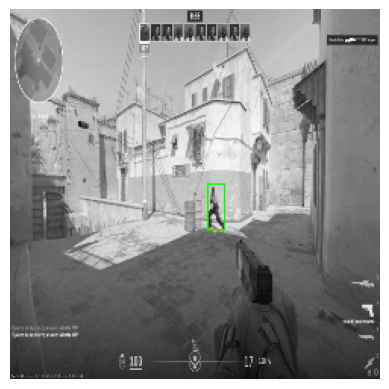

In [ ]:
# Read sample image (in grayscale)
temp_img = cv.imread("Counter-Strike-1/train/train_data/csdata_105-2-_png.rf.56ca4d76887906d553590ee163b42668.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.55859375, 0.53828125, 0.05078125, 0.12890625]

# Format sample
temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

# Draw box around player at the given coordinates
cv.rectangle(temp_color_img, box, (0, 255, 0), 1)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

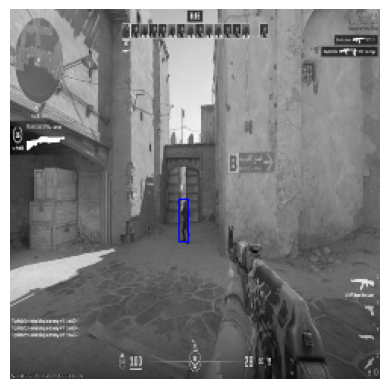

In [ ]:
# Read sample image (in grayscale)
temp_img = cv.imread("Counter-Strike-1/train/train_data/csdata_109-3-_png.rf.ecfaa7bb9c0a1aaf96cbbe1a42c8cc90.jpg", cv.IMREAD_GRAYSCALE)
temp_box = [0.4734375, 0.5734375, 0.0296875, 0.12109375]

# Format sample
temp_img_formated, box = format_image(temp_img, temp_box)

temp_color_img = cv.cvtColor(temp_img_formated, cv.COLOR_GRAY2RGB)

# Draw box around player at the given coordinates
cv.rectangle(temp_color_img, box, (0, 0, 255), 1)

plt.imshow(temp_color_img)
plt.axis("off")
plt.show()

Loading the dataset and preparing for use

Data Loading and Preprocessing:
  - Loading Images: Images are loaded using OpenCV's cv.imread() function. Grayscale images are used (cv.IMREAD_GRAYSCALE), which reduces the computational cost compared to color images.

  - Loading Labels: Bounding box coordinates and class labels are found from the images corresponding text file. This is what allows the model to determine the accuracy by comparing the predicted label to the actual label

Data Preprocessing:
  - Image and Label Normalization: Images are normalized by dividing the pixel values by 255 to put them all into the range of [0, 1]. This normalization helps the model converge towards the optimal solution during training. Bounding box coordinates are normalized based on the input size to ensure they properly scale with the images

Data Conversion:
  - Numpy Array Conversion: Images are converted into numpy arrays for better processing. Numpy arrays are very commonly used in deep learning models and are compatible with many ML frameworks.

  - Tensor Conversion: Numpy arrays are converted into TensorFlow tensors using tf.convert_to_tensor(). This allows for compatibility with TensorFlow's graphs and differentiation during model training.

Dataset Creation:
  - TensorFlow Dataset: TensorFlow dataset is created using tf.data.Dataset.from_tensor_slices(), which allows for better handling of large datasets.

Return:
  - Dataset: The function returns a TensorFlow dataset containing preprocessed images and their corresponding labels.

In [ ]:
def data_load(files, full_data_path="Counter-Strike-1/train/train_data", image_ext=".jpg"):
    # Lists to store images (X) and labels (Y)
    X = []
    Y = []

    # Iterate over files in the list of files
    for file in files:
        # Read the image in grayscale
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        # Initialize label k
        k = 1

        # Open the corresponding text file to read the label and bounding box
        with open(os.path.join(full_data_path, file + ".txt"), 'r') as fp:
            line = fp.readlines()[0]
            if line[0] == '0':
                k = 0

            # Bounding box coordinates
            box = np.array(line[1:].split(), dtype=float)

        # Format the image and bounding box
        img, box = format_image(img, box)

        # Normalize the pixel values of the image to the range [0, 1]
        img = img.astype(float) / 255.

        # Normalize the bounding box coordinates to the range [0, 1]
        box = np.asarray(box, dtype=float) / input_size

        # Combine the normalized bounding box coordinates and label into a single array
        label = np.append(box, k)

        # Append the formatted image and label to the lists
        X.append(img)
        Y.append(label)

    # Convert the lists of images and labels to numpy arrays
    X = np.array(X)

    # Add a channel dimension to the images
    X = np.expand_dims(X, axis=3)

    # Convert numpy arrays to TensorFlow tensors
    X = tf.convert_to_tensor(X, dtype=tf.float32)
    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    # Create a TensorFlow dataset
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [ ]:
raw_train_ds = data_load(training_files)

In [ ]:
CLASSES = 2

def format_instance(image, label):
    return image, (tf.one_hot(int(label[4]), CLASSES), [label[0], label[1], label[2], label[3]])

Here we use the format_instance function for each element in the dataset by using the map functionality. num_parallel_calls=tf.data.AUTOTUNE lets TensorFlow choose the most optimal amount of parallelism for based on the available resources. This ensures that everysingle datapoint is valid and prepared for training.

Next, shuffling the dataset with a buffer size of 1024 and setting reshuffle_each_iteration=True to ensure the dataset is shuffled for each epoch. This introduces some randomness to the training to stop the model from just memorizing patterns in the training data.

Prefetching elements from the dataset overlaps with data preprocessing and model training, which will significantly improve training time by reducing idle time between loading the data and model training. This ensures the model is constantly getting data, maximizing training throughput.

In [ ]:
BATCH_SIZE = 32

def tune_training_ds(dataset):
    # Apply the format_instance function
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)

    # Shuffle the dataset
    dataset = dataset.shuffle(1024, reshuffle_each_iteration=True)
    dataset = dataset.repeat()

    # Apply batch size
    dataset = dataset.batch(BATCH_SIZE)

    # Prefetch elements from the dataset to improve performance
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_ds = tune_training_ds(raw_train_ds)

This is just another point of visualization before training occurs. One last check after all data preparation to make sure everything is accurate and correct.

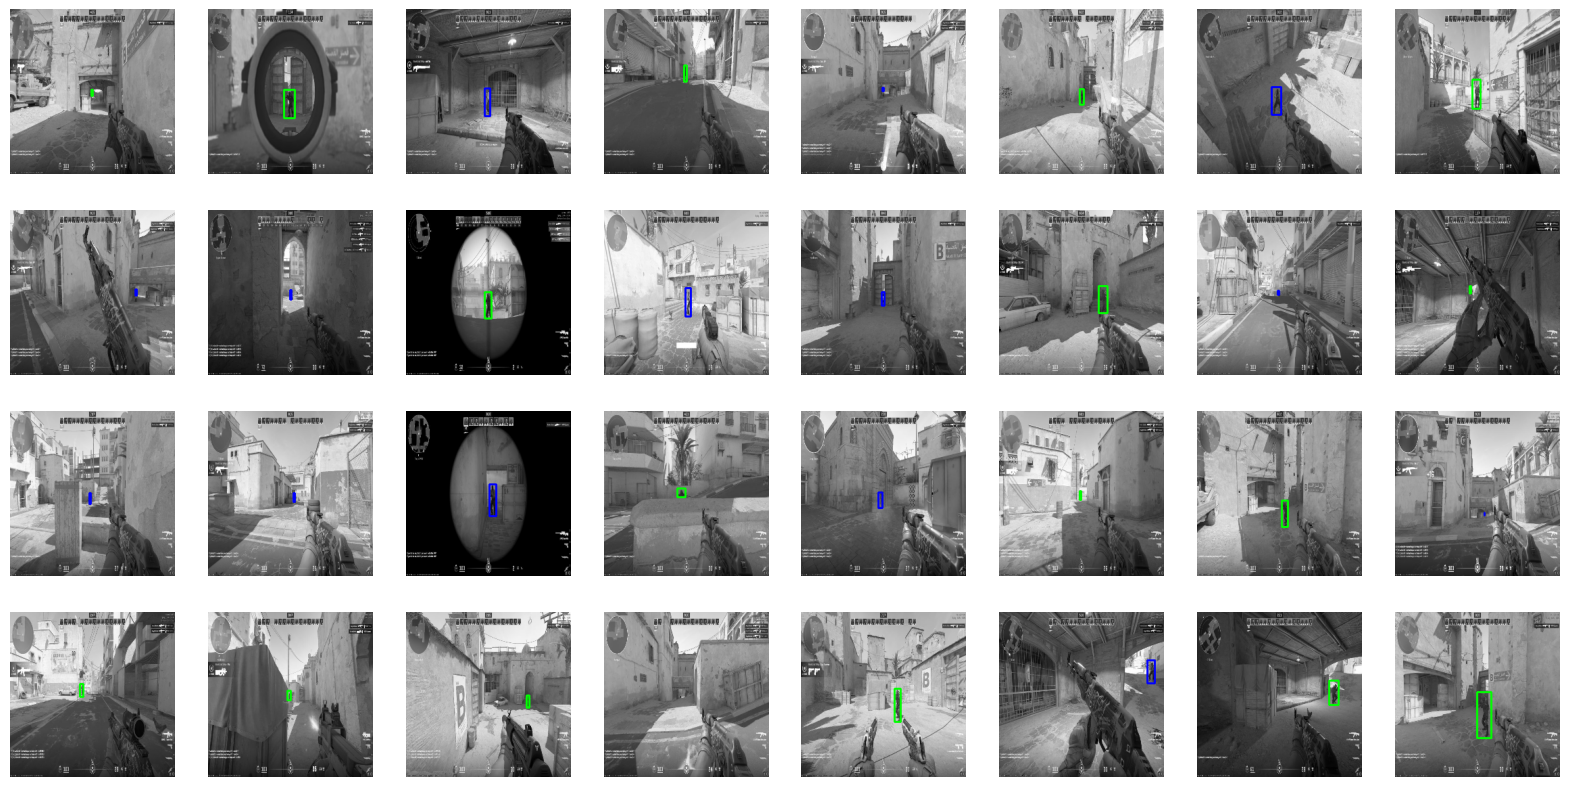

In [ ]:
plt.figure(figsize=(20, 10))
for images, labels in train_ds.take(1):
    for i in range(BATCH_SIZE):
        # Create subplots for each image in a grid format
        ax = plt.subplot(4, BATCH_SIZE//4, i + 1)

        # Extract label and bounding box info
        label = labels[0][i]
        box = (labels[1][i] * input_size)
        box = tf.cast(box, tf.int32)

        image = images[i].numpy().astype("float") * 255.0
        image = image.astype(np.uint8)
        image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

        color = (0, 0, 255)
        if label[0] > 0:
            color = (0, 255, 0)

        # Draw bounding box
        cv.rectangle(image_color, box.numpy(), color, 2)

        plt.imshow(image_color)
        plt.axis("off")

## **Model Architecture**

As mentioned in the introduction, object detection must combine classification and localization, or in other words it must perform regression to find the bounding box coordinates and classification to predict the objects label. With that being said, this custom model will consist of a regressor and a classifier which means it will give two outputs.

- **Classifier:**
  - Predict the class of the object in the image, in this model it will be classifying CT or T.

- **Regressor**
  - Predict the coordinates of the bounding box, with our data the coordinates are listed as x, y, width, height. With x and y being the top left corner of the bounding box.

**Feature Extractor:**
- This function defines the first layers responsible for extracting features from the images.
- It constructs a series of convolutional layers which are then followed by batch normalization and average pooling.
- The convolutional layers are used to learn features from the images which could help the model when classifying later images, and batch normalization helps improve and speed up the training. Average pooling reduces the dimensions of the feature maps for simplicity.

**Model Adaptor:**
- Flattens the output of the feature extractor and passes it through a dense layer with 64 nodes and ReLU activation.
- This will reshape high dimensional feature maps to be a flat vector and, making them more valid for classification and regression.

**Classifier Head:**
- Defines the output layer for classification, consisting of a dense layer with the softmax activation function, giving probabilities for the classification of each image.

**Regressor Head:**
- Defines the output layer for regression, consisting of a dense layer with a linear activation function, resulting in four output values which represent coordinates of the bounding box.

In [ ]:
DROPOUT_FACTOR = 0.5

def model_feature_extractor(inputs):
    # First convolutional layer with 16 filters, ReLU activation, and BatchNormalization
    x = tf.keras.layers.Conv2D(16, kernel_size=3, activation='relu', input_shape=(input_size, input_size, 1))(inputs)
    x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)  # Average Pooling layer

    # Second convolutional layer with 32 filters, ReLU activation, and BatchNormalization
    x = tf.keras.layers.Conv2D(32, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)  # Average Pooling layer

    # Third convolutional layer with 64 filters, ReLU activation, BatchNormalization, and Dropout
    x = tf.keras.layers.Conv2D(64, kernel_size=3, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization()(x)  # Add BatchNormalization
    x = tf.keras.layers.Dropout(DROPOUT_FACTOR)(x)  # Dropout layer
    x = tf.keras.layers.AveragePooling2D(2, 2)(x)  # Average Pooling layer

    return x

def model_adaptor(inputs):
    # Flatten the input
    x = tf.keras.layers.Flatten()(inputs)

    # Dense layer with 64 units and ReLU activation
    x = tf.keras.layers.Dense(64, activation='relu')(x)
    return x

def model_classifier(inputs):
    # Output layer for classification with softmax activation
    return tf.keras.layers.Dense(CLASSES, activation='softmax', name='classifier')(inputs)

def model_regressor(inputs):
    # Output layer for regression with 4 units (for bounding box coordinates)
    return tf.keras.layers.Dense(units=4, name='regressor')(inputs)

def build_model(inputs):
    extractor = model_feature_extractor(inputs)
    adaptor = model_adaptor(extractor)
    classification = model_classifier(adaptor)
    regressor = model_regressor(adaptor)

    model = tf.keras.Model(inputs=inputs, outputs=[classification, regressor])

    # Define the learning rate schedule
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=0.0001,
        decay_steps=10000,
        decay_rate=0.9
    )

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss={'classifier': 'categorical_crossentropy', 'regressor': 'mse'},
        metrics={'classifier': 'accuracy', 'regressor': 'mse'}
    )

    return model


In [ ]:
model = build_model(tf.keras.layers.Input(shape=(input_size, input_size, 1,)))

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 244, 244, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 242, 242, 16)         160       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 242, 242, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 average_pooling2d (Average  (None, 121, 121, 16)         0         ['batch_normalization[0][0

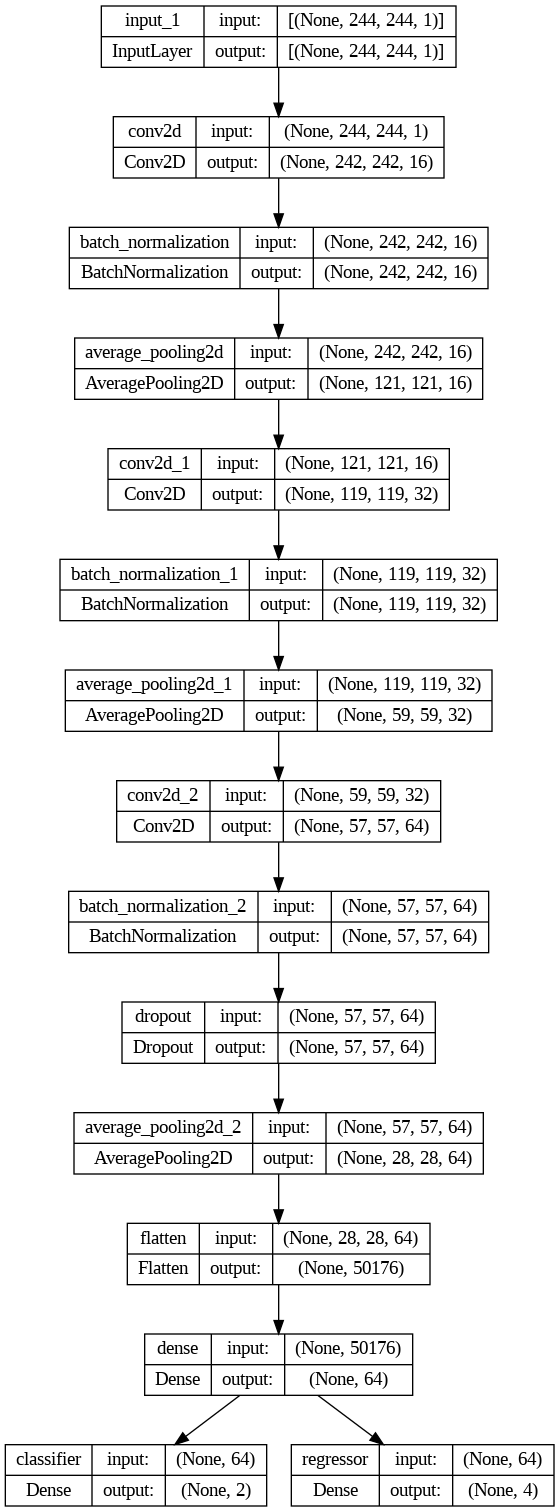

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

This function is to simply keep track of the training. The current epoch and baatch will be displayed, and the last 5 images of each epoch will be saved to a train_results folder so we can see the progress and improvements of training.

In [ ]:
class CustomCallback(Callback):
    def __init__(self):
        self.save_dir = 'train_results'

        self.epoch = 0

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch
        print(f'Starting Epoch {epoch+1}')

    def on_epoch_end(self, epoch, logs=None):
        # Generate and save some images at the end of each epoch
        for i, (image, labels) in enumerate(train_ds.take(5)):  # Save 5 images
            predictions = self.model.predict(image)
            predicted_box = predictions[1][0] * input_size
            predicted_box = tf.cast(predicted_box, tf.int32)

            # Prep for visualization
            image = image[0]
            image = image * 255.0
            image = image.numpy().astype(np.uint8)
            image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

            # Draw bounding box
            cv.rectangle(image_color, predicted_box.numpy(), (0, 255, 0), 1)

            # Save image
            filename = os.path.join(self.save_dir, f"epoch_{epoch}_image_{i}.png")
            cv.imwrite(filename, image_color)

    def on_batch_begin(self, batch, logs=None):
        print(f'Epoch {self.epoch + 1}, Batch {batch+1}')

    def on_batch_end(self, batch, logs=None):
        pass

## Training

The model will be trained for 100 epochs with batches of 32. The callback function is called to monitor the training **process**

In [ ]:
EPOCHS = 100

# Train model
history = model.fit(train_ds,
                    steps_per_epoch=(len(training_files) // BATCH_SIZE), # Number of batches per epoch
                    epochs=EPOCHS, # Number of epochs for training
                    callbacks=[CustomCallback()])

Streaming output truncated to the last 5000 lines.
Epoch 25, Batch 15
15/58 [======>.......................] - ETA: 1s - loss: 0.0762 - classifier_loss: 0.0463 - regressor_loss: 0.0299 - classifier_accuracy: 0.9917 - regressor_mse: 0.0299Epoch 25, Batch 16
Epoch 25, Batch 17
17/58 [=======>......................] - ETA: 1s - loss: 0.0738 - classifier_loss: 0.0440 - regressor_loss: 0.0298 - classifier_accuracy: 0.9926 - regressor_mse: 0.0298Epoch 25, Batch 18
Epoch 25, Batch 19
19/58 [========>.....................] - ETA: 1s - loss: 0.0738 - classifier_loss: 0.0440 - regressor_loss: 0.0298 - classifier_accuracy: 0.9918 - regressor_mse: 0.0298Epoch 25, Batch 20
Epoch 25, Batch 21
21/58 [=========>....................] - ETA: 1s - loss: 0.0729 - classifier_loss: 0.0433 - regressor_loss: 0.0297 - classifier_accuracy: 0.9926 - regressor_mse: 0.0297Epoch 25, Batch 22
Epoch 25, Batch 23
23/58 [==========>...................] - ETA: 1s - loss: 0.0730 - classifier_loss: 0.0428 - regressor_loss

## Displaying Training Results

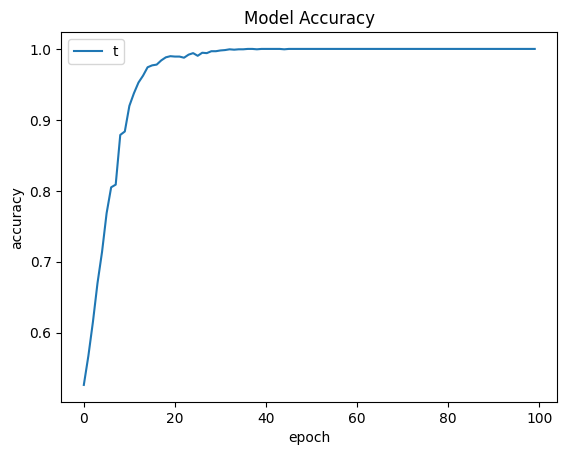

In [ ]:
plt.plot(history.history['classifier_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()

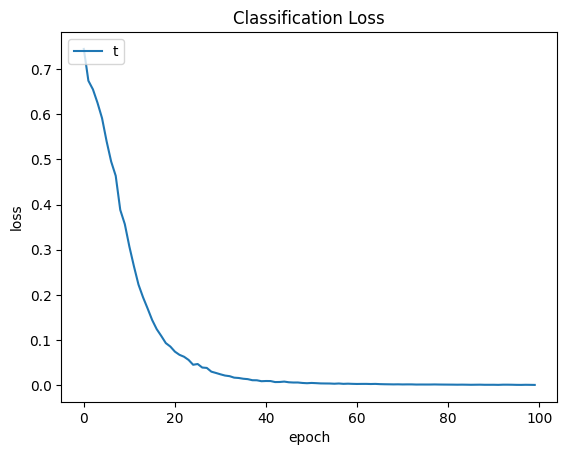

In [ ]:
plt.plot(history.history['classifier_loss'])
plt.title('Classification Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()

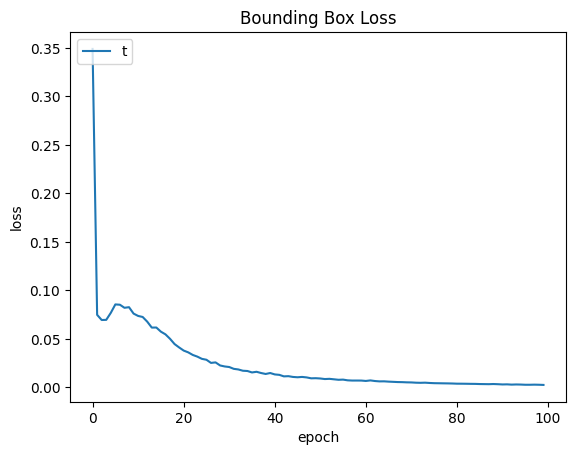

In [ ]:
plt.plot(history.history['regressor_loss'])
plt.title('Bounding Box Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()

## More result analysis

This function will calculate the intersection over union (IoU) which is the percentage over overlap between the predicted and real bounding boxes, showing the accuracy of the localization.

In [ ]:
def intersection_over_union(boxA, boxB):
	# Calculate the coordinates of the intersection
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
	yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])

	# Area of intersection
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)

	# Area of both bounding boxes
	boxAArea = (boxA[2] + 1) * (boxA[3] + 1)
	boxBArea = (boxB[2] + 1) * (boxB[3] + 1)

	# Intersection over union (IoU)
	iou = interArea / float(boxAArea + boxBArea - interArea)
	return iou

## Testing

With the model trained, it's now time to test the models performance on the test set!

In [ ]:
def test_data_load(files, full_data_path = "Counter-Strike-1/test/test_data", image_ext = ".jpg"):
    # Lists to store data and labels
    X = []
    Y = []

    for file in files:
        # Read the image file using OpenCV
        img = cv.imread(os.path.join(full_data_path, file + image_ext), cv.IMREAD_GRAYSCALE)

        k = 1

        # Open and read the label file
        with open(full_data_path + "/" + file + ".txt", 'r') as fp:
            line = fp.readlines()[0]
            # Check the class label
            if line[0] == '0':
                k = 0

            # Bounding box coordinates
            box = np.array(line[1:].split(), dtype=float)

        img, box = format_image(img, box)
        img = img.astype(float) / 255.
        box = np.asarray(box, dtype=float) / input_size
        label = np.append(box, k)

        # Append to lists
        X.append(img)
        Y.append(label)

    # Convert lists to NumPy array
    X = np.array(X)

    X = np.expand_dims(X, axis=3)

    # Convert to TensorFlow tensor
    X = tf.convert_to_tensor(X, dtype=tf.float32)

    Y = tf.convert_to_tensor(Y, dtype=tf.float32)

    # Create TensorFlow dataset
    result = tf.data.Dataset.from_tensor_slices((X, Y))

    return result

In [ ]:
raw_test_ds = test_data_load(testing_files)

Similar to the training set, we can apply the proper format to the test data

In [ ]:
def tune_test_ds(dataset):
    # Apply the format_instance function
    dataset = dataset.map(format_instance, num_parallel_calls=tf.data.AUTOTUNE)

    # Apply batch size
    dataset = dataset.batch(1)
    dataset = dataset.repeat()
    return dataset

test_ds = tune_test_ds(raw_test_ds)

40


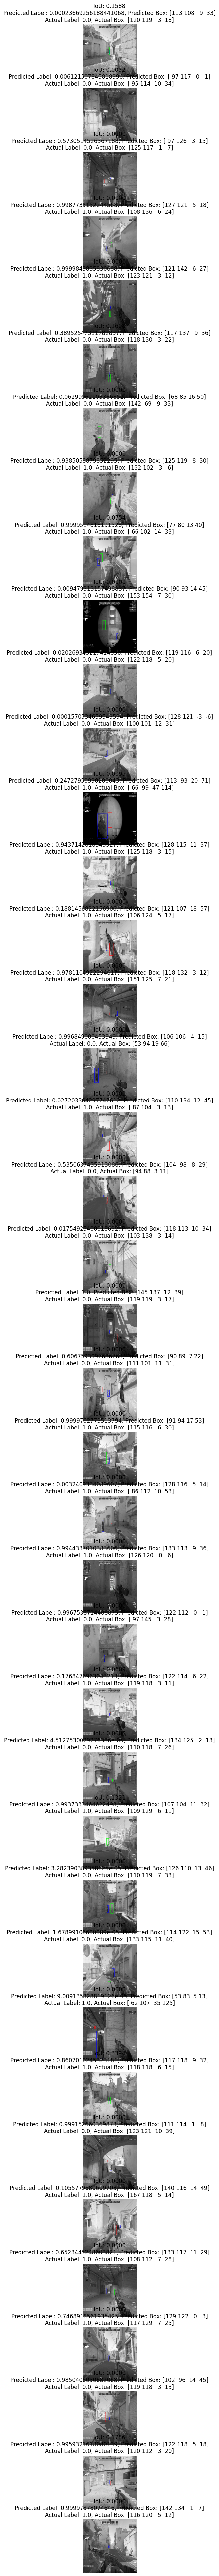

In [ ]:
plt.figure(figsize=(200, 100))

# Convert test dataset to a list for iteration
test_list = list(test_ds.take(40).as_numpy_iterator())

print(len(test_list))

# Iterate over each sample in the test dataset
for i, (image, labels) in enumerate(test_list):

    ax = plt.subplot(40, 1, i + 1)

    # Make predictions using the model
    predictions = model(image)

    # Predicted label and bounding box
    predicted_box = predictions[1][0] * input_size
    predicted_box = tf.cast(predicted_box, tf.int32)
    predicted_label = predictions[0][0]

    # Actual label and bounding box
    image = image[0]
    actual_label = labels[0][0]
    actual_box = labels[1][0] * input_size
    actual_box = tf.cast(actual_box, tf.int32)

    image = image.astype("float") * 255.0
    image = image.astype(np.uint8)
    image_color = cv.cvtColor(image, cv.COLOR_GRAY2RGB)

    color = (255, 0, 0)
    # print box red if predicted and actual label do not match
    if (predicted_label[0] > 0.5 and actual_label[0] > 0) or (predicted_label[0] < 0.5 and actual_label[0] == 0):
        color = (0, 255, 0)

    # Draw actual and predicted bounding boxes
    cv.rectangle(image_color, predicted_box.numpy(), color, 1)
    cv.rectangle(image_color, actual_box.numpy(), (0, 0, 255), 1)

    IoU = intersection_over_union(predicted_box.numpy(), actual_box.numpy())

    # Format the label string to include both class and box coordinates
    label_string = "IoU: {:.4f}\nPredicted Label: {}, Predicted Box: {}\nActual Label: {}, Actual Box: {}".format(
        IoU,
        predicted_label[0],
        predicted_box.numpy(),
        actual_label[0],
        actual_box.numpy()
    )

    plt.title(label_string)
    plt.imshow(image_color)
    plt.axis("off")

---

# **YOLOv5s Model**

YOLO is commonly regarded as one of the best models for computer vision tasks, which is exactly the reason I chose to use it for the transfer learning portion of my project. Using the YOLO model is relatively straightforward, after creating a dataset we can open the YOLO notebook and begin by cloning the repository and installing all requirements. In the training set we can input our datasets API key to access it from RoboFlow. For training we can specify the image size, number of epochs, batch size, and the default weights of the YOLO model. To keep it short, the model is composed of 214 total layers, 7,025,023 parameters, and 7,025,023 gradients.

```
Model:                    YOLOv5s
Size (pixels):            640
mAPbox 50-95:             37.6
mAPmask 50-95:            31.7
Train Time (300 Epochs):  88:16
Speed (ONNX CPU):         173.3
Speed (TRT A100):         1.4
Params:                   7.6
```

## Justification for choosing YOLOv5s (small)

- **Model Size**
  - YOLOv5s is the second smallest version of YOLOv5 in terms of size and computational complexity. It contains fewer parameters than YOLOv5m, YOLOv5l, and YOLOv5x, which makes it perfect for the limited resources at my disposal for this project.

- **Speed and Efficiency**
  - YOLOv5s is specifically designed for real-time inference and use of limited computational resources. The smaller model size gives it a speed advantage over the larger models, making it preferable for applications that need low-latency real-time object detection such as aimbot.

- **Performance**
  - Even though this version of YOLOv5 is much smaller in size, it can still compete with the detection performance of larger models.

In [ ]:
!git clone https://github.com/ultralytics/yolov5  # clone YOLOv5 repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies
%pip install -q roboflow

In [ ]:
from IPython.display import Image, clear_output

In [ ]:
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

In [ ]:
os.environ["DATASET_DIRECTORY"] = "/content/datasets"

In [ ]:
from roboflow import Roboflow
rf = Roboflow(api_key="X1WLdPiFrXXFn4rJIKPE")
project = rf.workspace("counter-strike-uovxc").project("counter-strike-h9y80")
version = project.version(1)
dataset = version.download("yolov5")

In [ ]:
!python train.py --img 416 --batch 64 --epochs 50 --data {dataset.location}/data.yaml --weights yolov5s.pt --cache

In [ ]:
# Start tensorboard
# Launch after you have started training
# logs save in the folder "runs"
%load_ext tensorboard
%tensorboard --logdir runs

In [ ]:
!python detect.py --weights runs/train/exp/weights/best.pt --img 416 --conf 0.1 --source {dataset.location}/test/images

In [ ]:
#display inference on ALL test images

for imageName in glob.glob('/content/yolov5/runs/detect/exp/*.jpg'):
    display(Image(filename=imageName))
    print("\n")

In [ ]:
# Path to the directory you want to zip
folder_path = '/content/yolov5/runs/detect/exp/'

# Path for the zip file
zip_file_path = '/content/exp.zip'

# Create a zip file of the 'exp' folder
shutil.make_archive('/content/exp', 'zip', folder_path)

# Move the zip file to a downloadable location
shutil.move('/content/exp.zip', zip_file_path)

# Download the zip file

files.download(zip_file_path)

#export your model's weights for future use
files.download('./runs/train/exp/weights/best.pt')



---


# **Results**

## Custom Model

My custom model performs seemingly well on the training data, reaching a very low loss in box predictions, classification, and overall accuracy. Despite this the model seems to fall short when it comes to testing. Given the limited amount of time left in this project I was not able to fullly address and fix this issue, however I do believe the issue is caused by either a bias in the training data or not a complex enough model. Due to this, the model is unfortunately unable to accurately identify players who appear outside the center of the screen or players that are only partially visible.

## YOLOv5s Model

The YOLO model does well differentiating between the ct and t classes, only misclassifying t as ct 3% of the time and vice versa 1% of the time. The main issue with the YOLO model is misclassifying random objects in the background as a player, predicting ct 51% of the time when it's just random objects, and 49% of the time for the t class. Another area of error is 9% a true t is classified as background and 11% of the time true ct is classified as background. Clearly this is an issue as in my initial proposal I expressed that one of the most important errors to try to minimize is the false negatives rate, which will ensure the model won’t miss players that show up on the screen.



---



# **Conclusion**

In this project I used my collected data to explore the difference in performance of a pre-trained/optimized model for object detection and my own custom model for object detection.

While both models have their strengths and weaknesses, there is a clear winner when it comes to performance. The YOLOv5s model absolutely embarrasses my model in all areas, mainly classification and localization. However, I dont feel too bad about YOLO performing better as this just shows how complax of a task object detection can be. YOLO has been built and tweaked, and improved for a long time, while my model was developed in a mere ~4 weeks with very limited computational resources. It was motivational to see the slight progress of my model over the past few weeks as I built and modified it, and when comparing it to the YOLO model it's even more motivational knowing what it could become.

## What did I learn?

I learned a LOT, and one of the things I learned was that this is something that is really interesting to me and I would love to work in the Deep Learning or Machine Learning feild some day!

For the technical stuff I learned, I had to do lots of research about object detection models, reading articles about facial recognition, Tesla cars self driving ability, and more to get a better understanding of how these models work. I worked with lots of new libraries and tools I've never used before such as OpenCV, TensorFlow, and a few more. One thing that came as a challenge was building a model that combined bounding box regression and object classification, as well as figuring out what architectures, loss functions, and hyperparameters were best for these tasks. 

The main take away from this is that these tasks are hard and complex, pre-trained models exist for a reason. After using YOLO with relative easy, the custom model was a big challenge which made me realize why so much money and time is typically put into all the models and deep learning systems we see on a regular basis. 

Overall this project really challenged me and pushed me to explore new things in depth, while at the same time deepening my interest in the overall topic of Deep Learning!

## Future Work

In the future I would love to continue working on this project. Firstly I would like to take my YOLOv5 model a step further and actually implement it as an aimbot. Secondly I want to continue working on and improving my custom model, getting it to work with higher accuracy in testing by implementing a more complex model